In [1]:
import os
import sys
import cProfile
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import n2j.inference.infer_utils as iutils
from n2j.inference.inference_manager import InferenceManager
from n2j.config_utils import get_config_modular

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Hierarchical inference

__Author:__ Ji Won Park (@jiwoncpark)

__Created:__ 7/10/2021 

__Last run:__ 8/10/2021

__Goal__: Using the BNN-generated $\kappa$ posteriors, we 
1. infer the population-level distribution in $\kappa$ using importance sampling and 
2. use this information to reweight the individual BNN posteriors so that the interim (training) prior is divided out and the new, inferred test prior reapplied.

__Before running:__
From the repo root, run
```
python n2j/infer.py <path to config file>
```

Let's read in the config file, which contains various configs used in training and to be used in inference.

In [2]:
cfg = get_config_modular(['../tuning_configs_local/nersc_config_T2.yml'])

We then instantiate the `InferenceManager` and load the training dataset.

In [3]:
infer_obj = InferenceManager(checkpoint_dir=cfg['trainer']['checkpoint_dir'],
                                 **cfg['inference_manager'])
# Load training stats (for normalizing data)
norm_obj = getattr(stats, cfg['data']['train_dist_name'])(**cfg['data']['train_dist_kwargs'])
train_raytracing = [os.path.join(cfg['data']['in_dir'],
                                 f'cosmodc2_{hp}/Y_{hp}') for hp in cfg['data']['train_hp']]
infer_obj.load_dataset(
                       dict(features=cfg['data']['features'],
                            raytracing_out_dirs=train_raytracing,
                            healpixes=cfg['data']['train_hp'],
                            n_data=cfg['data']['n_train'],
                            aperture_size=1.0,
                            subsample_pdf_func=norm_obj.pdf,
                            stop_mean_std_early=False,
                            in_dir=cfg['data']['in_dir']),
                       sub_features=cfg['data']['sub_features'],
                       sub_target=cfg['data']['sub_target'],
                       sub_target_local=cfg['data']['sub_target_local'],
                       is_train=True,
                       batch_size=cfg['data']['batch_size'],
                       num_workers=cfg['data']['num_workers'],
                       rebin=False,
                       noise_kwargs=cfg['data']['noise_kwargs'])

Mag errors added to ['u', 'g', 'r', 'i', 'z', 'y']


Next, let's load the test set, subsampling so that the test sightlines follow a narrow normal as defined by the config file.

In [4]:
test_raytracing = [os.path.join(cfg['data']['in_dir'],
                                    f'cosmodc2_{hp}/Y_{hp}') for hp in cfg['test_data']['test_hp']]
infer_obj.load_dataset(dict(features=cfg['data']['features'],
                                raytracing_out_dirs=test_raytracing,
                                healpixes=cfg['test_data']['test_hp'],
                                n_data=cfg['test_data']['n_test_pre_subsample'],
                                aperture_size=1.0,
                                subsample_pdf_func=None,
                                in_dir=cfg['data']['in_dir']),
                           sub_features=cfg['data']['sub_features'],
                           sub_target=cfg['data']['sub_target'],
                           sub_target_local=cfg['data']['sub_target_local'],
                           is_train=False,
                           batch_size=cfg['test_data']['batch_size'],
                           noise_kwargs=cfg['data']['noise_kwargs']
                           )
# Redefine test data to be the subset
norm_obj_test = getattr(stats, cfg['test_data']['dist_name'])(**cfg['test_data']['dist_kwargs'])
infer_obj.reset_test_dataset(norm_obj_test.pdf, n_test=cfg['test_data']['n_test'])

The test dataset now has size [100]


We have a broad training prior and a narrow, overdense (high-$\kappa$) test distribution.

(100000,) (100,) (50000,)


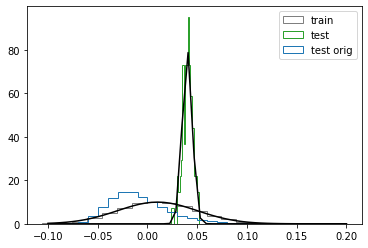

In [5]:
train_k = infer_obj.get_true_kappa(is_train=True).squeeze()
test_k_orig = infer_obj.get_true_kappa(is_train=False, add_suffix='orig').squeeze()
test_k = infer_obj.get_true_kappa(is_train=False).squeeze()

grid = np.linspace(-0.1, 0.2, 50)
print(train_k.shape, test_k.shape, test_k_orig.shape)
_, bins, _ = plt.hist(train_k, bins=20, density=True, color='tab:gray', label='train', histtype='step')
_ = plt.hist(test_k, bins=20, density=True, color='tab:green', label='test', histtype='step')
_ = plt.hist(test_k_orig, bins=20, density=True, color='tab:blue', label='test orig', histtype='step', range=[-0.1, 0.1])

plt.plot(grid, stats.norm.pdf(loc=0.01, scale=0.04, x=grid), color='k')
plt.plot(grid, stats.norm.pdf(loc=0.04, scale=0.005, x=grid), color='k')
plt.legend()


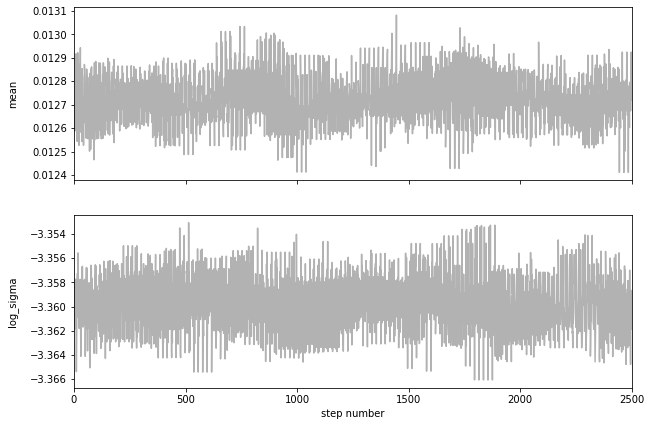

In [6]:
# Path to the stored MCMC chain
chain_path = os.path.join(infer_obj.out_dir, 'omega_chain.h5')
mcmc_samples = iutils.get_mcmc_samples(chain_path, 
                                       chain_kwargs=dict(flat=True, discard=75))
iutils.get_chain_plot(mcmc_samples, None)

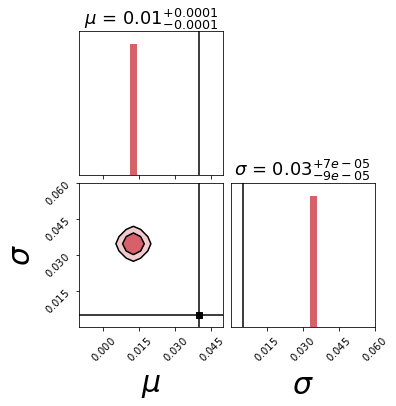

In [23]:
infer_obj.visualize_omega_post(log_idx=1,
                               chain_path=chain_path,
                               corner_kwargs=dict(
                                                 range=[[-0.01, 0.05], [0, 0.06]],
                                                 color='#d6616b',
                                                 smooth=1.0,
                                                 alpha=1.0,
                                                 truths=np.array([0.04, 0.005]),
                                                 label_kwargs={'fontsize': 30},
                                                 labels=[r'$\mu$', r'$\sigma$'],
                                                 fill_contours=True,
                                                 plot_datapoints=False,
                                                 plot_contours=True,
                                                 show_titles=True,
                                                 levels=[0.68, 0.95],
                                                 truth_color='k',
                                                 contour_kwargs=dict(linestyles='solid', colors='k'),
                                      #contourf_kwargs=dict(colors='#843c39'),
                                                 quiet=True,
                                                 #quantiles=[0.5 - 0.34, 0.5 + 0.34],
                                                 title_fmt=".1g",
                                                 fig=None,
                                                 title_kwargs={'fontsize': 18},
                                                 #range=[0.99]*len(cols_to_plot),
                                                 use_math_text=True,
                                                 hist_kwargs=dict(density=True, 
                                                                  histtype='stepfilled',))
                                                 ,
                               chain_kwargs=dict(
                                                 flat=True,
                                                 thin=1,
                                                 discard=55
                                                 ))

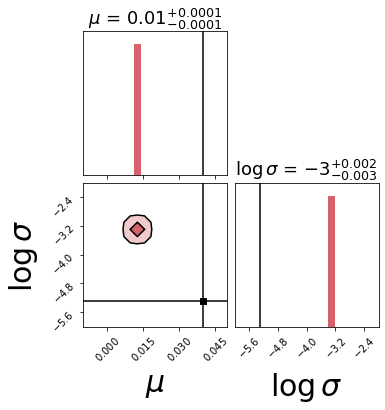

In [24]:
infer_obj.visualize_omega_post(log_idx=None,
                               chain_path=chain_path,
                               corner_kwargs=dict(
                                                 range=[[-0.01, 0.05], [-6, -2]],
                                                 color='#d6616b',
                                                 smooth=0.8,
                                                 alpha=1.0,
                                                 truths=np.array([0.04, np.log(0.005)]),
                                                 label_kwargs={'fontsize': 30},
                                                 labels=[r'$\mu$', r'$\log \sigma$'],
                                                 fill_contours=True,
                                                 plot_datapoints=False,
                                                 plot_contours=True,
                                                 show_titles=True,
                                                 levels=[0.68, 0.95],
                                                 truth_color='k',
                                                 contour_kwargs=dict(linestyles='solid', colors='k'),
                                      #contourf_kwargs=dict(colors='#843c39'),
                                                 quiet=True,
                                                 #quantiles=[0.5 - 0.34, 0.5 + 0.34],
                                                 title_fmt=".1g",
                                                 fig=None,
                                                 title_kwargs={'fontsize': 18},
                                                 #range=[0.99]*len(cols_to_plot),
                                                 use_math_text=True,
                                                 hist_kwargs=dict(density=True, 
                                                                  histtype='stepfilled',))
                                                 ,
                               chain_kwargs=dict(
                                                 flat=True,
                                                 thin=1,
                                                 discard=55
                                                 ))

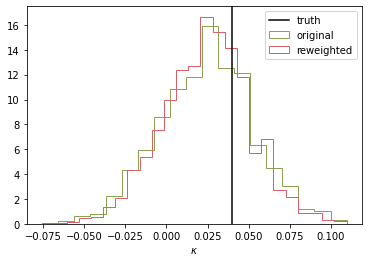

In [14]:
infer_obj.visualize_kappa_post(idx=1, n_samples=50, n_mc_dropout=20,
                               chain_path=chain_path, 
                               interim_pdf_func=norm_obj.pdf,
                               chain_kwargs=dict(
                                                 flat=True,
                                                 thin=1,
                                                 discard=0
                                                 ))